# Energy consumption prediction using LSTM/GRU in PyTorch

## The ML Pipeline

In [1]:
# Built-in libraries
import os
import time
import gc
from pathlib import Path

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Local modules
from fct import GRUNet, LSTMNet
from fct import sMAPE, evaluate, move_sliding_window

In [2]:
print(torch.__version__)

2.7.1+cpu


# Evaluating models
#### __Note: Running the following codes needs at least 16GB of memory.__
Moving on to measuring the accuracy of both models, we'll now use our `evaluate()` function and test dataset.

## Load data

In [3]:
# Import of parameters
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
# Accès aux variables
label_col_index = config["label_col_index"]
inputs_cols_indices = config["inputs_cols_indices"]
window_size = config["window_size"]
num_files_for_dataset = config["num_files_for_dataset"]

In [4]:
# Paths
data_raw_path = Path.cwd().parent / "data" / "raw"
data_processed_path = Path.cwd().parent / "data" / "processed"
model_path = Path.cwd().parent / "models"

In [5]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_raw_path) if os.path.splitext(file)[1] == ".csv"
]

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_raw_path, file), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df = df.assign(
        hour=df["Datetime"].dt.hour,
        dayofweek=df["Datetime"].dt.dayofweek,
        month=df["Datetime"].dt.month,
        dayofyear=df["Datetime"].dt.dayofyear,
    )
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )
    
    # Redure the precision of data
    data = data.astype(np.float32)
    inputs = inputs.astype(np.float32)
    labels = labels.astype(np.float32)

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]
    
    # Remove temporary variables
    del df, data, inputs, labels
    gc.collect()
    

  0%|          | 0/5 [00:00<?, ?it/s]

Processing AEP_hourly.csv ...
(121183, 90, 5) (121183, 1)
Processing COMED_hourly.csv ...
(66407, 90, 5) (66407, 1)
Processing DAYTON_hourly.csv ...
(121185, 90, 5) (121185, 1)
Processing DEOK_hourly.csv ...
(57649, 90, 5) (57649, 1)
Processing DOM_hourly.csv ...
(116099, 90, 5) (116099, 1)


## Load the GRU model

In [6]:
# Accès aux variables
n_hidden = config["n_hidden"]
hidden_dim = n_hidden
input_dim = config["input_dim"]
output_dim = config["output_dim"]
n_layers = config["n_layers"]

In [7]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

In [8]:
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load(os.path.join(model_path, "gru_model.pt")))

<All keys matched successfully>

In [9]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the LSTM model

In [10]:
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load(os.path.join(model_path, "lstm_model.pt")))

<All keys matched successfully>

In [11]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

## Model Evaluation

To compare the performance of both models, we will track the training time and ultimately compare their final accuracy on the test set. For the accuracy metric, we will use the **Symmetric Mean Absolute Percentage Error (sMAPE)**. 

The sMAPE measures the accuracy by calculating the average of the absolute difference between predicted values and actual values, normalized by the average of these two values. This results in a percentage that quantifies the amount of error symmetrically, which makes it suitable for comparing forecasts especially when values can be close to zero.

The formula for sMAPE is given by:

![sMAPE_formula](/home/briacleguillou/Documents/machine_learning/energy_consumption_prediction-master/imgs/sMAPE_formula.png)


## Evaluate performance of GRU

In [12]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 70.12 seconds
sMAPE: 0.32899999618530273%


## Evaluate performance of LSTM

In [13]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 39.11 seconds
sMAPE: 0.3319999873638153%


In [14]:
targets

[array([16370., 16517., 16935., ..., 17001., 15964., 14809.],
       shape=(12118,), dtype=float32),
 array([11271.   , 11372.999, 11403.   , ..., 15086.   , 14447.999,
        13334.999], shape=(6640,), dtype=float32),
 array([2063., 2061., 2119., ..., 2405., 2250., 2042.],
       shape=(12118,), dtype=float32),
 array([3504.    , 3482.0002, 3380.    , ..., 3851.    , 3575.    ,
        3281.    ], shape=(5764,), dtype=float32),
 array([ 9618.   ,  9803.   ,  9870.   , ..., 13312.   , 12390.001,
        11385.   ], shape=(11609,), dtype=float32)]

While the GRU model may have made smaller errors and edged the LSTM model slightly in terms of performance accuracy, the difference is insignificant and thus inconclusive. There have been many other tests conducted by others comparing both these models but there has largely been no clear winner as to which is the better architecture overall.

In [15]:
len(
    gru_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

5

In [16]:
gru_outputs

[array([16453.824, 16465.635, 16965.863, ..., 16866.264, 16448.26 ,
        14844.908], shape=(12118,), dtype=float32),
 array([11475.729, 11717.247, 11434.178, ..., 14840.829, 14555.781,
        13555.337], shape=(6640,), dtype=float32),
 array([2079.679 , 2068.9888, 2117.5525, ..., 2393.905 , 2300.404 ,
        2078.8562], shape=(12118,), dtype=float32),
 array([3533.5215, 3453.4382, 3417.6345, ..., 3710.0283, 3729.6992,
        3221.3416], shape=(5764,), dtype=float32),
 array([10135.49 , 10016.258,  9925.126, ..., 13411.374, 12443.183,
        11245.077], shape=(11609,), dtype=float32)]

# Some visualizations

Lastly, let's do some visualizations on random sets of our predicted output vs the actual consumption data for some states.

In [17]:
states_list = list(test_x.keys())

In [18]:
states_list

['AEP_hourly.csv',
 'COMED_hourly.csv',
 'DAYTON_hourly.csv',
 'DEOK_hourly.csv',
 'DOM_hourly.csv']

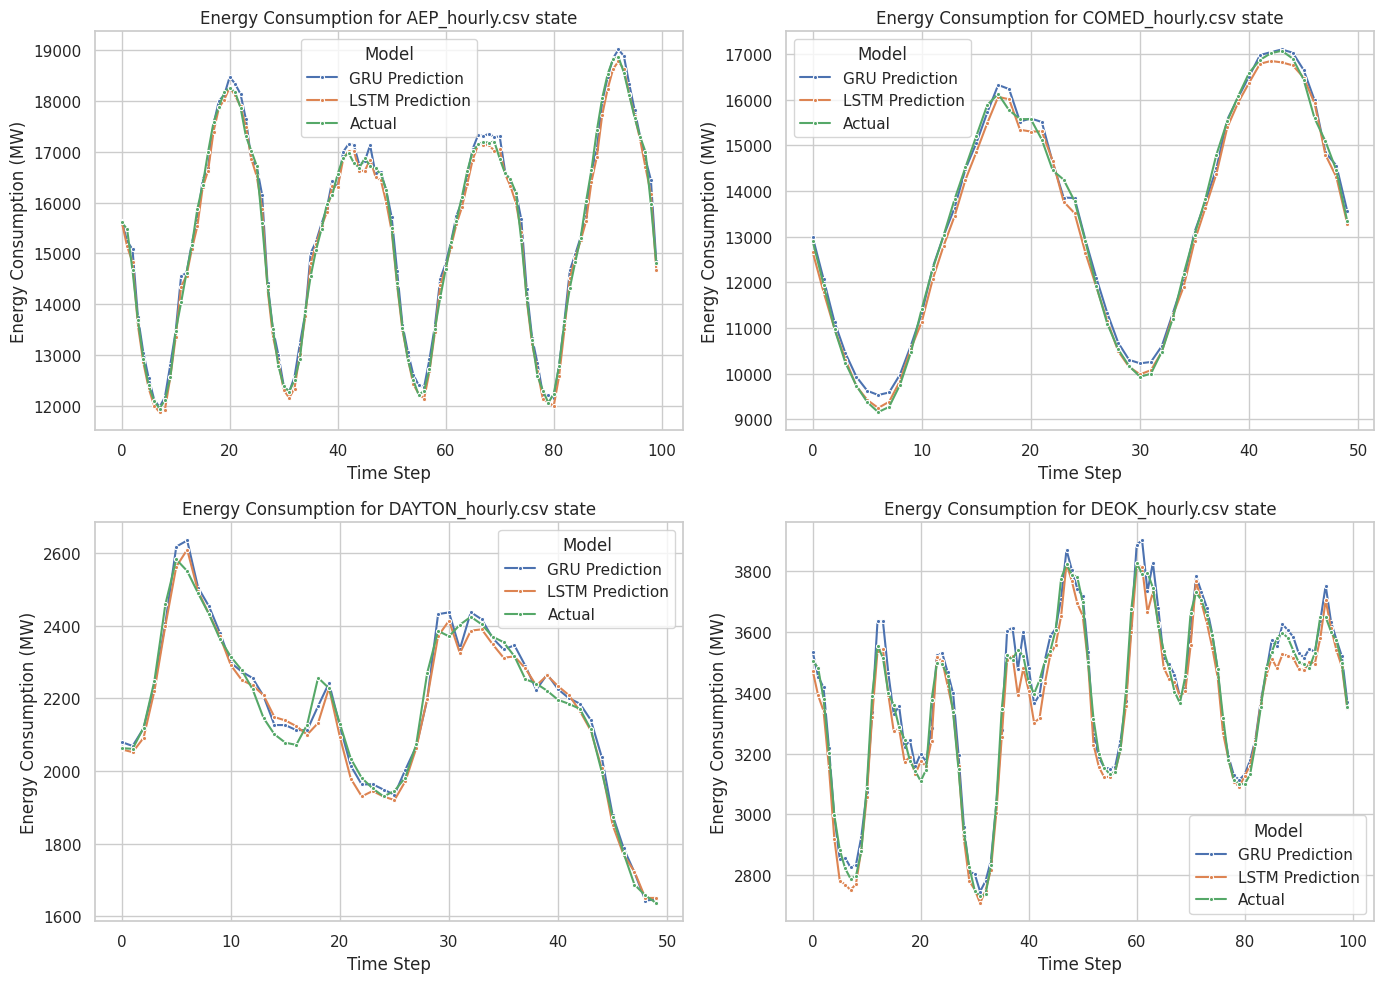

In [19]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

slices = [
    (-100, None),
    (-50, None),
    (0, 50),
    (0, 100),
]

for i, ax in enumerate(axes):
    start, end = slices[i]
    nb = end - start if end else abs(start)
    
    df = pd.DataFrame({
        "Time Step": range(nb),
        "GRU Prediction": gru_outputs[i][start:end],
        "LSTM Prediction": lstm_outputs[i][start:end],
        "Actual": targets[i][start:end],
    })

    df_melted = df.melt(id_vars="Time Step", 
                        value_vars=["GRU Prediction", "LSTM Prediction", "Actual"],
                        var_name="Model", value_name="Energy Consumption")

    sns.lineplot(data=df_melted, x="Time Step", y="Energy Consumption", hue="Model", ax=ax, marker="o", markersize=3)
    ax.set_title(f"Energy Consumption for {states_list[i]} state")
    ax.set_ylabel("Energy Consumption (MW)")

plt.tight_layout()
plt.show()

The models appear to be quite effective at capturing the overall trends in energy consumption. Although they may occasionally miss certain changes—such as delays in forecasting a drop in usage—their predictions closely track the actual values on the test set. This success can be attributed to the inherent patterns and cyclical nature of energy consumption data, which the models are able to learn. In contrast, more challenging time-series problems, like stock price or sales volume forecasting, often involve data that is more random or lacks clear patterns, resulting in generally lower predictive accuracy.

## What's next?

* Use more data.
* Use more complex (more layers) networks.